In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm

from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
learning_rate = 0.001
training_epochs = 30
batch_size = 2000

In [4]:
F_MNIST_train = dsets.FashionMNIST('F_MNIST_data/',
                                   train=True,
                                   transform = transforms.ToTensor(),
                                   download=True)
F_MNIST_test = dsets.FashionMNIST('F_MNIST_data/',
                                  train=False,
                                  transform = transforms.ToTensor(),
                                  download=True)

In [5]:
data_loader = torch.utils.data.DataLoader(dataset=F_MNIST_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [6]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.6
        # L1 ImgIn shape = (batch_size, 1, 28, 28)
        #    Conv        = (batch_size, 32, 28, 28)
        #    Pool        = (batch_size, 32, 14, 14)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L2 ImgIn shape = (batch_size, 32, 14, 14)
        #    Conv        = (batch_size, 64, 14, 14)
        #    Pool        = (batch_size, 64, 7, 7)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L3 ImgIn shape = (batch_size, 64, 7, 7)
        #    Conv        = (batch_size, 128, 7, 7)
        #    Pool        = (batch_size, 128, 4, 4)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        # L4 FC 4x4x128 inputs -> 625 outputs
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        # L5 Final FC 625 inputs -> 10 outputs
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.layer4(out)
        out = self.fc2(out)
        return out

In [7]:
model = CNN().to(device)

In [8]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
total_batch = len(data_loader)
model.train()  # set the model to train mode
count = 0
for epoch in tqdm(range(training_epochs)):
    avg_cost = 0

    for X, Y in data_loader:
        count += 1
        X = X.to(device)
        Y = Y.to(device)

        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch
        writer.add_scalar("Loss/train", avg_cost, count)
    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

print('Learning Finished!')

[Epoch:    1] cost = 1.07825541
[Epoch:    2] cost = 0.557242572
[Epoch:    3] cost = 0.449047208
[Epoch:    4] cost = 0.391332895
[Epoch:    5] cost = 0.354662091
[Epoch:    6] cost = 0.326459914
[Epoch:    7] cost = 0.306105137
[Epoch:    8] cost = 0.292995989
[Epoch:    9] cost = 0.277209401
[Epoch:   10] cost = 0.266371727
[Epoch:   11] cost = 0.254466891
[Epoch:   12] cost = 0.244307742
[Epoch:   13] cost = 0.23468861
[Epoch:   14] cost = 0.232570007
[Epoch:   15] cost = 0.219376609
[Epoch:   16] cost = 0.215404183
[Epoch:   17] cost = 0.209257469
[Epoch:   18] cost = 0.202142179
[Epoch:   19] cost = 0.198704198
[Epoch:   20] cost = 0.196237624
[Epoch:   21] cost = 0.195744604
[Epoch:   22] cost = 0.182896838
[Epoch:   23] cost = 0.177220047
[Epoch:   24] cost = 0.174922198
[Epoch:   25] cost = 0.165861264
[Epoch:   26] cost = 0.165042445
[Epoch:   27] cost = 0.159632012
[Epoch:   28] cost = 0.154940367
[Epoch:   29] cost = 0.152734891
[Epoch:   30] cost = 0.148421764

Learning Fi

In [10]:
with torch.no_grad():
    model.eval()    # set the model to evaluation mode (dropout=False)

    X_test = F_MNIST_test.data.view(len(F_MNIST_test), 1, 28, 28).float().to(device)
    Y_test = F_MNIST_test.targets.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.8422999978065491


In [11]:
def label_string(label_num):
    if label_num == 0:
        label_s = "T-Shirt/Top"
    elif label_num == 1:
        label_s = "Trouser"
    elif label_num == 2:
        label_s = "Pullover"
    elif label_num == 3:
        label_s = "Dress"
    elif label_num == 4:
        label_s = "Coat"
    elif label_num == 5:
        label_s = "Sandals"
    elif label_num == 6:
        label_s = "Shirt"
    elif label_num == 7:
        label_s = "Sneaker"
    elif label_num == 8:
        label_s = "Bag"
    elif label_num == 9:
        label_s = "Ankle boots"
    else:
        print("should not reach here")
        
    return label_s

Prediction : Shirt
Correct : Shirt


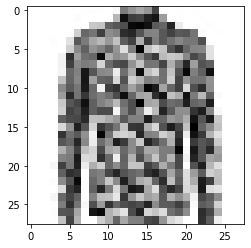

In [37]:
# Single Prediction
with torch.no_grad():
    model.eval()
    
    r = random.randint(0, len(F_MNIST_test)-1)
    
    X_single_test = F_MNIST_test.data[r:r+1].view(1, 1, 28, 28).float().to(device)
    Y_single_test = F_MNIST_test.targets[r:r+1]
    
    single_pred = torch.argmax(model(X_single_test), 1)
    
    print('Prediction : %s' % label_string(single_pred))
    print('Correct : %s' % label_string(Y_single_test))
    plt.imshow(X_single_test.cpu().view(28, 28),
               cmap='Greys', interpolation='nearest')
    plt.show()